#1 Introdução
Este estudo tem como objetivo desenvolver e avaliar modelos preditivos para classificação de risco de crédito, utilizando técnicas de aprendizado de máquina supervisionado. A base de dados utilizada foi obtida da plataforma Kaggle, especificamente o arquivo credit_scoring.csv, que contém informações relevantes para análise de comportamento financeiro de clientes.

A análise foca em identificar clientes inadimplentes, representados pela variável alvo binária, a fim de auxiliar na tomada de decisão para concessão de crédito e mitigação de riscos financeiros. Foram aplicados métodos clássicos e robustos de classificação, incluindo Árvore de Decisão e Random Forest, com ajuste de hiperparâmetros e estratégias para lidar com o desbalanceamento das classes.

A metodologia contempla desde o pré-processamento dos dados, análise exploratória, definição dos conjuntos de treino e teste estratificados, até a avaliação dos modelos por meio de métricas de desempenho como F1-score, ROC AUC e matriz de confusão. Além disso, foi realizado ajuste de threshold baseado na estatística de Youden para otimizar a sensibilidade e especificidade do modelo, alinhando a solução ao contexto de negócios e reduzindo potenciais custos decorrentes de decisões erradas.

Este trabalho contribui para o entendimento das variáveis mais relevantes no comportamento de crédito e oferece um framework técnico replicável para modelagem preditiva em cenários financeiros.

##1.1 Importação de Bibliotecas

In [45]:
# Bibliotecas para manipulação e análise de dados
import pandas as pd                  # Manipulação de dados em formato tabular (DataFrame)
import numpy as np                   # Operações numéricas e vetorizadas

# Bibliotecas para visualização
import seaborn as sns                # Visualização estatística de dados (baseado em matplotlib)
import matplotlib.pyplot as plt      # Criação de gráficos e figuras

# Modelos de classificação
from sklearn.tree import DecisionTreeClassifier            # Classificador por árvore de decisão
from sklearn.ensemble import RandomForestClassifier        # Classificador Random Forest (ensemble de árvores)

# Utilitários para modelagem e avaliação
from sklearn.model_selection import GridSearchCV           # Busca de hiperparâmetros por grade (validação cruzada)
from sklearn.model_selection import train_test_split       # Separação entre dados de treino e teste
from sklearn.metrics import (
    roc_auc_score,                                         # AUC da curva ROC
    roc_curve,                                             # Curva ROC (taxa de verdadeiros positivos vs. falsos positivos)
    mean_squared_error, mean_absolute_error, r2_score,     # Métricas de regressão (úteis se modelo híbrido for usado)
    classification_report, accuracy_score                  # Métricas de classificação
)
from sklearn.preprocessing import StandardScaler           # Normalização/padronização de features

# Visualização de estrutura de árvores
from sklearn.tree import plot_tree                         # Plotagem de árvore de decisão

# Matriz de confusão
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay  # Matriz e visualização de confusão




##1.2 Importação da base de dados

In [28]:
df = pd.read_csv("/content/drive/MyDrive/ML/credito_bank/data_procesed/data_mod_numb_risck/db_model_risck.csv")

#2. Análise de Correlação entre Variáveis Numéricas
####Objetivo
- Visualizar o grau de correlação entre variáveis numéricas do dataset.
- Identificar possíveis **multicolinearidades** (correlações fortes entre variáveis independentes), que podem impactar negativamente modelos lineares ou afetar a interpretabilidade do modelo.
- Observar relações fortes com a variável-alvo (se presente na matriz) para orientar a **seleção de features** ou análise de importância.

#### Interpretação
- Correlação próxima de **+1** indica forte correlação positiva.
- Correlação próxima de **–1** indica forte correlação negativa.
- Correlação próxima de **0** indica ausência de correlação linear.



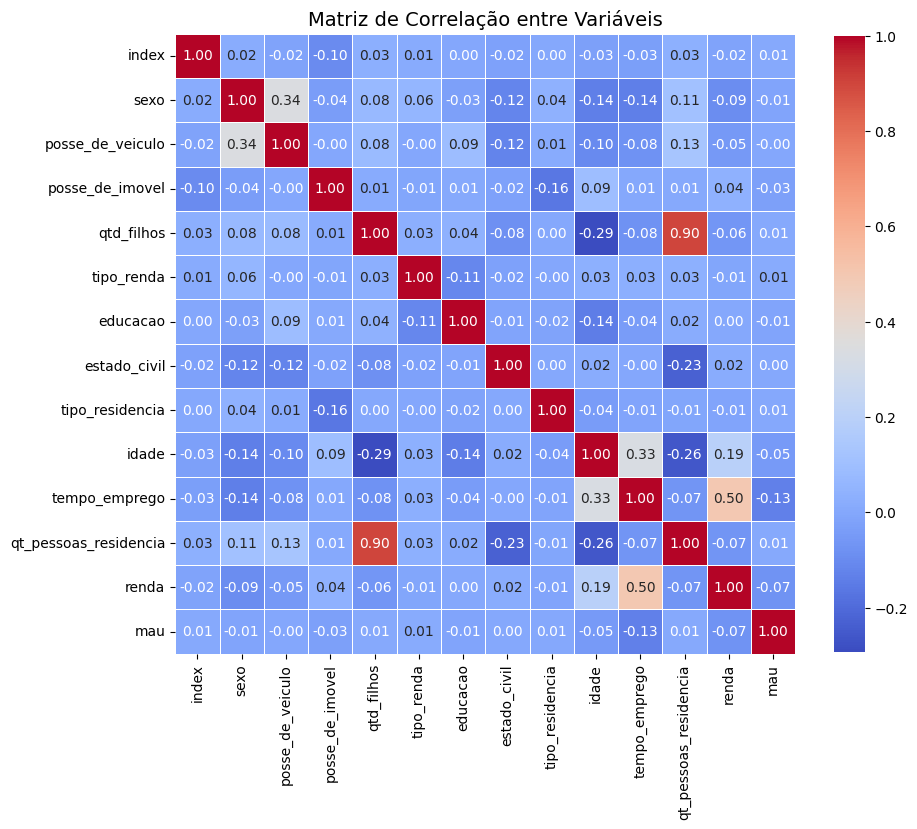

In [57]:
# Define o tamanho da figura para melhor visualização da matriz de correlação
plt.figure(figsize=(10, 10))

# Gera um heatmap com as correlações entre as variáveis numéricas do DataFrame
sns.heatmap(df.corr(),            # Matriz de correlação de Pearson
            annot=True,           # Exibe os valores numéricos nas células do mapa
            cmap='coolwarm',      # Paleta de cores (opcional, mas recomendada para contraste)
            square=True,          # Formata as células como quadrados
            fmt=".2f",            # Formato dos números com duas casas decimais
            linewidths=0.5,       # Espaçamento entre os quadrantes
            cbar_kws={"shrink": 0.8})  # Reduz o tamanho da barra de cor
plt.title("Matriz de Correlação entre Variáveis", fontsize=14)
plt.show()


#3. Separação entre Variáveis Independentes (X) e Dependente (y)

#### Objetivo
- **X (features):** Contém todas as variáveis preditoras que serão utilizadas para treinar o modelo.
- **y (target):** Contém a variável de interesse, que o modelo tentará prever.
  - Neste caso, `"mau"` representa o comportamento de inadimplência do cliente (binária: 0 = bom pagador, 1 = mau pagador).

####Observações
- A separação clara entre `X` e `y` é essencial para a aplicação de algoritmos supervisionados de classificação.
- A nomenclatura padrão `X` e `y` facilita a compatibilidade com funções da biblioteca `scikit-learn`.
- Certifique-se de que `X` contenha apenas variáveis numéricas ou codificadas, especialmente se modelos baseados em distância ou árvore forem utilizados.


In [30]:
X = df.drop("mau", axis= 1)
y= df["mau"]

In [31]:
X.head()

,index,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda
0,5733,0,0,0,0,0,0,1,0,43,6.873973,1.0,2515.39
1,727,0,1,1,0,4,0,0,0,35,4.526027,2.0,3180.19
2,6374,0,0,0,2,4,0,0,0,31,0.243836,4.0,1582.29
3,9566,0,0,0,0,4,0,0,0,54,12.772603,2.0,13721.17
4,9502,0,1,0,0,4,1,1,0,31,8.432877,1.0,2891.08


In [32]:
y.head()

,mau
0,0
1,0
2,0
3,0
4,0


##3.1 Separação dos Dados em Conjunto de Treino e Teste

####Objetivo
Separar os dados para:
- **Treinamento do modelo (`X_train`, `y_train`)**
- **Avaliação da performance em dados não vistos (`X_test`, `y_test`)**

####Estratificação (`stratify=y`)
- Garante que a **distribuição da variável alvo "mau"** (classe 0 vs 1) seja mantida proporcionalmente nos conjuntos de treino e teste.
- Isso é essencial quando há **desequilíbrio de classes**, pois evita que o conjunto de teste fique desbalanceado.

####Observações
- `random_state=42` assegura que a divisão dos dados seja **reproduzível**, o que é importante para rastreabilidade de experimentos.
- A escolha de `test_size=0.2` (20%) é uma prática comum, mas pode ser ajustada conforme o volume de dados disponível.


In [58]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2, stratify = y, random_state = 42)

#4. Instanciação do Modelo: Árvore de Decisão (Decision Tree Classifier)

####Objetivo
Criar um classificador baseado em regras hierárquicas (árvore de decisão) com **restrições para controlar complexidade** e **evitar overfitting**.

####Hiperparâmetros escolhidos
- `max_depth=5`: Limita a profundidade da árvore, reduzindo a complexidade e aumentando a generalização.
- `min_samples_split=10`: Um nó só será dividido se contiver ao menos 10 amostras.
- `min_samples_leaf=5`: Cada nó folha deve conter pelo menos 5 amostras, o que evita a criação de ramos muito específicos.
- `max_leaf_nodes=20`: Limita o número total de nós folha, ajudando a conter a complexidade do modelo.
- `random_state=42`: Permite reprodutibilidade dos resultados ao fixar a aleatoriedade interna.

####Sobre Árvores de Decisão
- São interpretáveis e capazes de capturar relações não lineares entre as variáveis.
- Sensíveis a pequenas variações nos dados (por isso os hiperparâmetros são importantes para estabilidade).



In [59]:
modelo_arvore = DecisionTreeClassifier(
    max_depth=5,
    min_samples_split=10,
    min_samples_leaf=5,
    max_leaf_nodes=20,
    random_state=42
)

In [60]:
# Treinamento do modelo de árvore de decisão utilizando os dados de treino
modelo_arvore.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=5, max_leaf_nodes=20, min_samples_leaf=5,
                       min_samples_split=10, random_state=42)

##4.1 Avaliação do Modelo com Métricas de Classificação

####Objetivo
Avaliar a **performance preditiva** do modelo `modelo_arvore` nos dados de teste (`X_test`) usando métricas clássicas de classificação.

####`classification_report`
Esse relatório fornece:
- **Precision (Precisão):** Proporção de acertos entre as previsões positivas.
- **Recall (Revocação / Sensibilidade):** Proporção de acertos entre os casos positivos reais.
- **F1-score:** Média harmônica entre precisão e recall (mais robusta em casos de desbalanceamento).
- **Support:** Quantidade de ocorrências reais de cada classe no conjunto de teste.

####Observações Técnicas
- Essencial quando se trata de **problemas com classes desbalanceadas**, como inadimplência.
- O modelo pode ter **alta acurácia global**, mas desempenho ruim para a **classe minoritária** — nesse caso, métricas como `recall` e `f1-score` para a classe 1 (mau) são críticas.


In [61]:
y_pred = modelo_arvore.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.92      1.00      0.96    115162
           1       0.54      0.03      0.06      9647

    accuracy                           0.92    124809
   macro avg       0.73      0.51      0.51    124809
weighted avg       0.90      0.92      0.89    124809



##4.2 Otimização de hiperparâmetros com Grid Search + Validação cruzada

####Objetivo
Encontrar a **melhor combinação de hiperparâmetros** para o modelo `DecisionTreeClassifier` que maximize o desempenho em termos de `f1-score` (considerando o equilíbrio entre precisão e recall).

####Parâmetros Avaliados
- `max_depth`: Controla a profundidade da árvore (evita overfitting).
- `min_samples_split`: Controla quando dividir um nó.
- `min_samples_leaf`: Controla o tamanho mínimo de um nó folha.
- `max_leaf_nodes`: Limita a complexidade da árvore.

####Estratégia de Validação
- **Validação cruzada com 5 folds (`cv=5`)**: A média das performances nos 5 subconjuntos é usada para avaliar cada combinação.
- **Métrica `f1`**: Indicada para problemas com classes desbalanceadas, pois penaliza fortemente erros na classe minoritária.

####Desempenho Computacional
- `n_jobs=-1`: Utiliza todos os núcleos do processador para paralelizar a busca e acelerar o processo.

> Após essa etapa, o modelo ideal está disponível via `grid.best_estimator_`.


In [ ]:
# Define a grade de hiperparâmetros a ser testada
param_grid = {
    'max_depth': [3, 5, 10],                    # Profundidade máxima da árvore
    'min_samples_split': [2, 5, 10, 20],        # Mínimo de amostras para dividir um nó
    'min_samples_leaf': [1, 2, 5, 10],          # Mínimo de amostras em um nó folha
    'max_leaf_nodes': [10, 20, 50]              # Máximo número de nós folha
}

# Instancia o objeto GridSearchCV com validação cruzada (cv=5) e avaliação baseada em F1-score
grid = GridSearchCV(
    estimator=DecisionTreeClassifier(random_state=42),  # Estimador base
    param_grid=param_grid,                              # Grade de parâmetros
    cv=5,                                                # Validação cruzada com 5 folds
    scoring='f1',                                        # Métrica de avaliação (F1-score para lidar com desbalanceamento)
    n_jobs=-1                                            # Utiliza todos os núcleos disponíveis (paralelismo)
)

# Executa a busca pelos melhores hiperparâmetros no conjunto de treino
grid.fit(X_train, y_train)

# Exibe a melhor combinação encontrada
print("Melhores parâmetros:", grid.best_params_)


Melhores parâmetros: {'max_depth': 3, 'max_leaf_nodes': 10, 'min_samples_leaf': 1, 'min_samples_split': 2}


In [63]:
modelo_arvore_balanceado = DecisionTreeClassifier(
    max_depth = 3,
    max_leaf_nodes = 10,
    min_samples_leaf = 1,
    min_samples_split = 2,
    class_weight='balanced',
    random_state = 42
)

In [64]:
modelo_arvore_balanceado.fit(X_train, y_train)

DecisionTreeClassifier(class_weight='balanced', max_depth=3, max_leaf_nodes=10,
                       random_state=42)

In [65]:
y_pred = modelo_arvore_balanceado.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.97      0.67      0.79    115162
           1       0.16      0.76      0.27      9647

    accuracy                           0.68    124809
   macro avg       0.57      0.71      0.53    124809
weighted avg       0.91      0.68      0.75    124809



## 4.3 Visualização da Árvore de Decisão Treinada

####Objetivo
Visualizar a **estrutura hierárquica de decisão** aprendida pelo modelo de árvore para:
- Interpretar os **critérios de divisão em cada nó**.
- Entender **quais variáveis estão sendo mais utilizadas** na árvore.
- Avaliar o **nível de pureza dos nós** (proporção de uma única classe em cada folha).
- Auxiliar na **explicabilidade do modelo**, especialmente útil para tomada de decisão em negócios.

####Componentes do gráfico
- **Cada nó** exibe:
  - A regra de divisão (`feature <= valor`)
  - A quantidade de amostras
  - A distribuição de classes
  - A classe majoritária no nó
- **As cores** representam a predominância de uma das classes: quanto mais intensa, mais puro o nó.

####Observações
- Esse tipo de visualização é especialmente útil para modelos **shallow** (profundidade controlada).

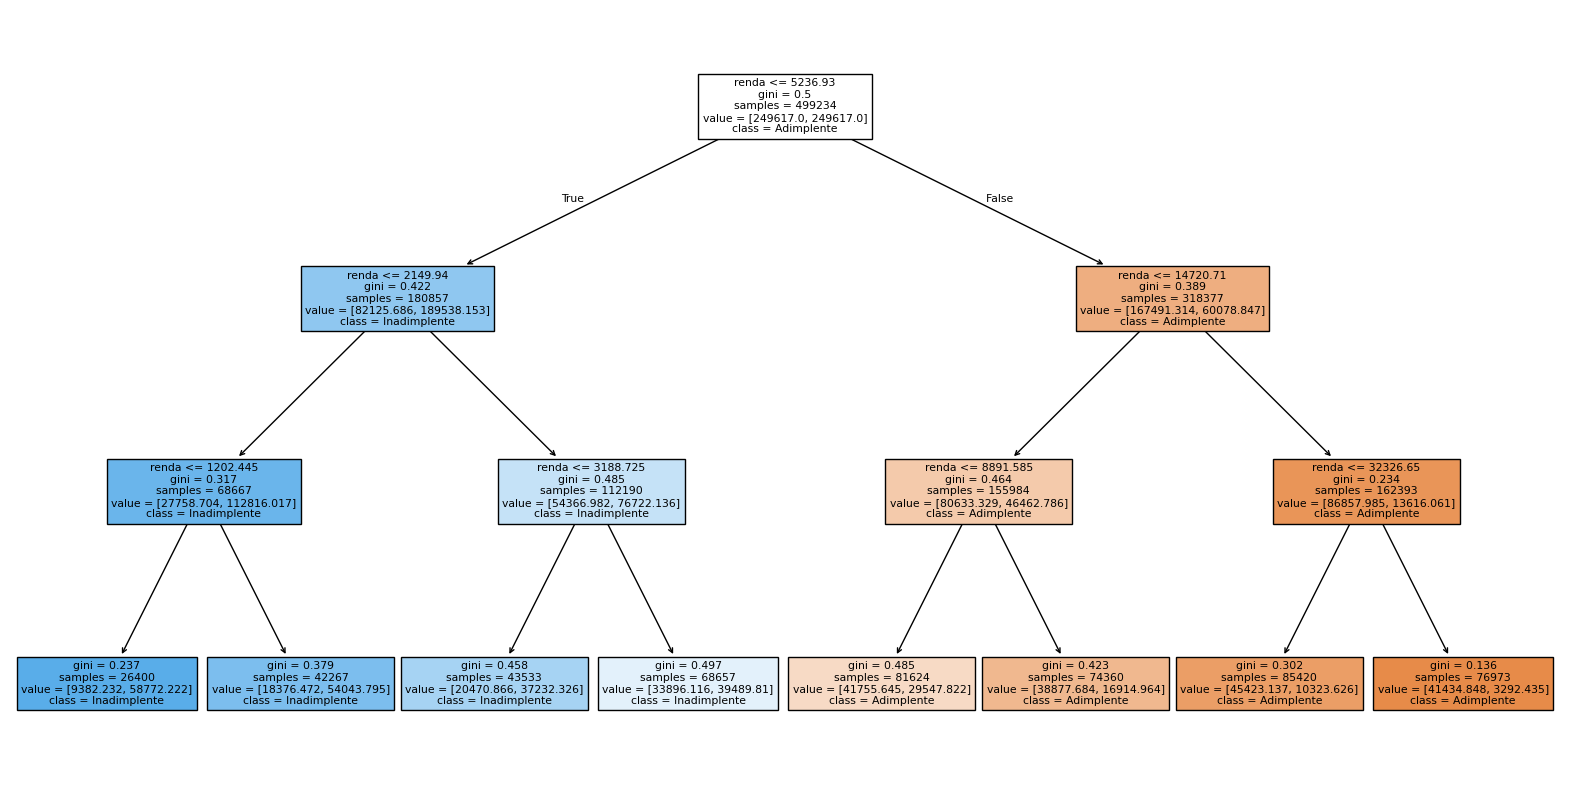

In [66]:
# Define o tamanho da figura para que a árvore seja renderizada com clareza
plt.figure(figsize=(20, 10))

# Plota a estrutura da árvore de decisão treinada
plot_tree(
    modelo_arvore_balanceado,            # Modelo treinado (assumido como versão balanceada e otimizada)
    feature_names=X.columns,             # Nomes das features (colunas do DataFrame original)
    class_names=["Adimplente", "Inadimplente"],  # Rótulos das classes
    filled=True                          # Preenchimento de cores nos nós (reflete a pureza da classe)
)

# Exibe o gráfico
plt.show()

#5. Treinamento de Modelo Ensemble: Random Forest

####Objetivo
Criar e treinar um modelo de **Random Forest**, um algoritmo de aprendizado de máquina do tipo ensemble, que combina múltiplas árvores de decisão para melhorar a **generalização** e **reduzir o overfitting**.

####Parâmetros escolhidos
- `n_estimators=100`: A floresta será composta por 100 árvores de decisão, cada uma treinada com uma amostra bootstrap dos dados.
- `random_state=42`: Garante reprodutibilidade ao controlar a aleatoriedade no processo de amostragem e divisão de nós.

####Como o Random Forest funciona
- Cada árvore na floresta aprende um subconjunto diferente dos dados.
- As previsões são feitas por **votação majoritária** (no caso de classificação).
- Introduz **aleatoriedade nos splits**, escolhendo aleatoriamente um subconjunto de variáveis em cada divisão, o que aumenta a diversidade entre as árvores.

####Vantagens sobre uma única árvore
- Reduz a variância do modelo (menos sensível a ruído).
- Melhora a performance geral, especialmente em conjuntos de dados complexos e/ou com ruído.
- Permite medir **importância das variáveis** de forma agregada (`feature_importances_`).


In [40]:
modelo_floresta = RandomForestClassifier(n_estimators=100, random_state=42)
modelo_floresta.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [41]:
# Gera previsões com o modelo Random Forest nos dados de teste
y_pred = modelo_floresta.predict(X_test)

# Exibe métricas de classificação para avaliação do modelo
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.93      0.98      0.95    115224
           1       0.26      0.10      0.14      9585

    accuracy                           0.91    124809
   macro avg       0.59      0.54      0.55    124809
weighted avg       0.88      0.91      0.89    124809



In [42]:
# Obtém as probabilidades preditas da classe positiva (inadimplente) para o conjunto de teste
y_proba = modelo_floresta.predict_proba(X_test)[:, 1]

# Calcula a Área sob a Curva ROC (AUC)
roc_auc = roc_auc_score(y_test, y_proba)

# Exibe o valor do ROC AUC
print("ROC AUC:", roc_auc)

ROC AUC: 0.6733872926874946


##5.1 Otimização de Hiperparâmetros do Random Forest com Grid Search

####Objetivo
Encontrar a combinação ótima de hiperparâmetros para o modelo Random Forest visando maximizar o `f1-score`, especialmente importante em cenários com classes desbalanceadas.

####Detalhes dos Parâmetros:
- `max_depth`: Limita a profundidade das árvores para controlar overfitting.
- `min_samples_split`: Define o mínimo de amostras necessárias para dividir um nó.
- `min_samples_leaf`: Número mínimo de amostras necessárias em cada nó folha.
- `class_weight='balanced'`: Ajusta automaticamente os pesos das classes inversamente proporcional à sua frequência, ajudando o modelo a aprender melhor a classe minoritária.

####Configurações do GridSearchCV:
- `cv=5`: Validação cruzada para garantir robustez da avaliação.
- `scoring='f1'`: Prioriza equilíbrio entre precisão e recall.
- `n_jobs=2`: Paraleliza a execução usando dois núcleos da CPU para acelerar o processo.
- `verbose=2`: Apresenta logs detalhados do andamento da busca.


In [ ]:
param_grid = {
    'max_depth': [5, 10, 20],
    'min_samples_split': [5, 10],
    'min_samples_leaf': [2, 5],
    'class_weight':['balanced']
}

grid = GridSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_grid=param_grid,
    scoring='f1',
    cv=5,
    n_jobs=2,
    verbose=2
)
grid.fit(X_train, y_train)
print("Melhores parâmetros:", grid.best_params_)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


/usr/local/lib/python3.11/dist-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Melhores parâmetros: {'class_weight': 'balanced', 'max_depth': 20, 'min_samples_leaf': 5, 'min_samples_split': 5}


In [43]:
# Instanciação do Random Forest com hiperparâmetros otimizados e balanceamento de classes
modelo_floresta_balanceado = RandomForestClassifier(
    max_depth=20,               # Profundidade máxima da árvore, para melhor captura de complexidade
    min_samples_leaf=5,         # Mínimo de amostras por nó folha para evitar overfitting
    min_samples_split=5,        # Mínimo de amostras necessárias para divisão de um nó
    class_weight="balanced",    # Ajusta pesos para equilibrar as classes na aprendizagem
    random_state=42             # Garante reprodutibilidade
)

# Treinamento do modelo utilizando os dados de treino
modelo_floresta_balanceado.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', max_depth=20,
                       min_samples_leaf=5, min_samples_split=5,
                       random_state=42)

##5.2 Visualização de uma Árvore Individual dentro do Random Forest

####Objetivo
Visualizar a estrutura de uma árvore individual do conjunto Random Forest para:
- Entender as regras e decisões específicas geradas em uma das árvores do ensemble.
- Observar os critérios de divisão, distribuição de classes nos nós e a profundidade da árvore.
- Auxiliar na interpretação local do modelo, apesar de o Random Forest ser um modelo "black-box" coletivo.

####Observações
- Random Forest é composto por múltiplas árvores independentes treinadas em subconjuntos amostrados dos dados (bootstrap).
- Cada árvore pode apresentar diferenças significativas em estruturas e divisões.
- Visualizar árvores individuais pode ajudar a entender a diversidade do ensemble, mas não representa o comportamento global do modelo.



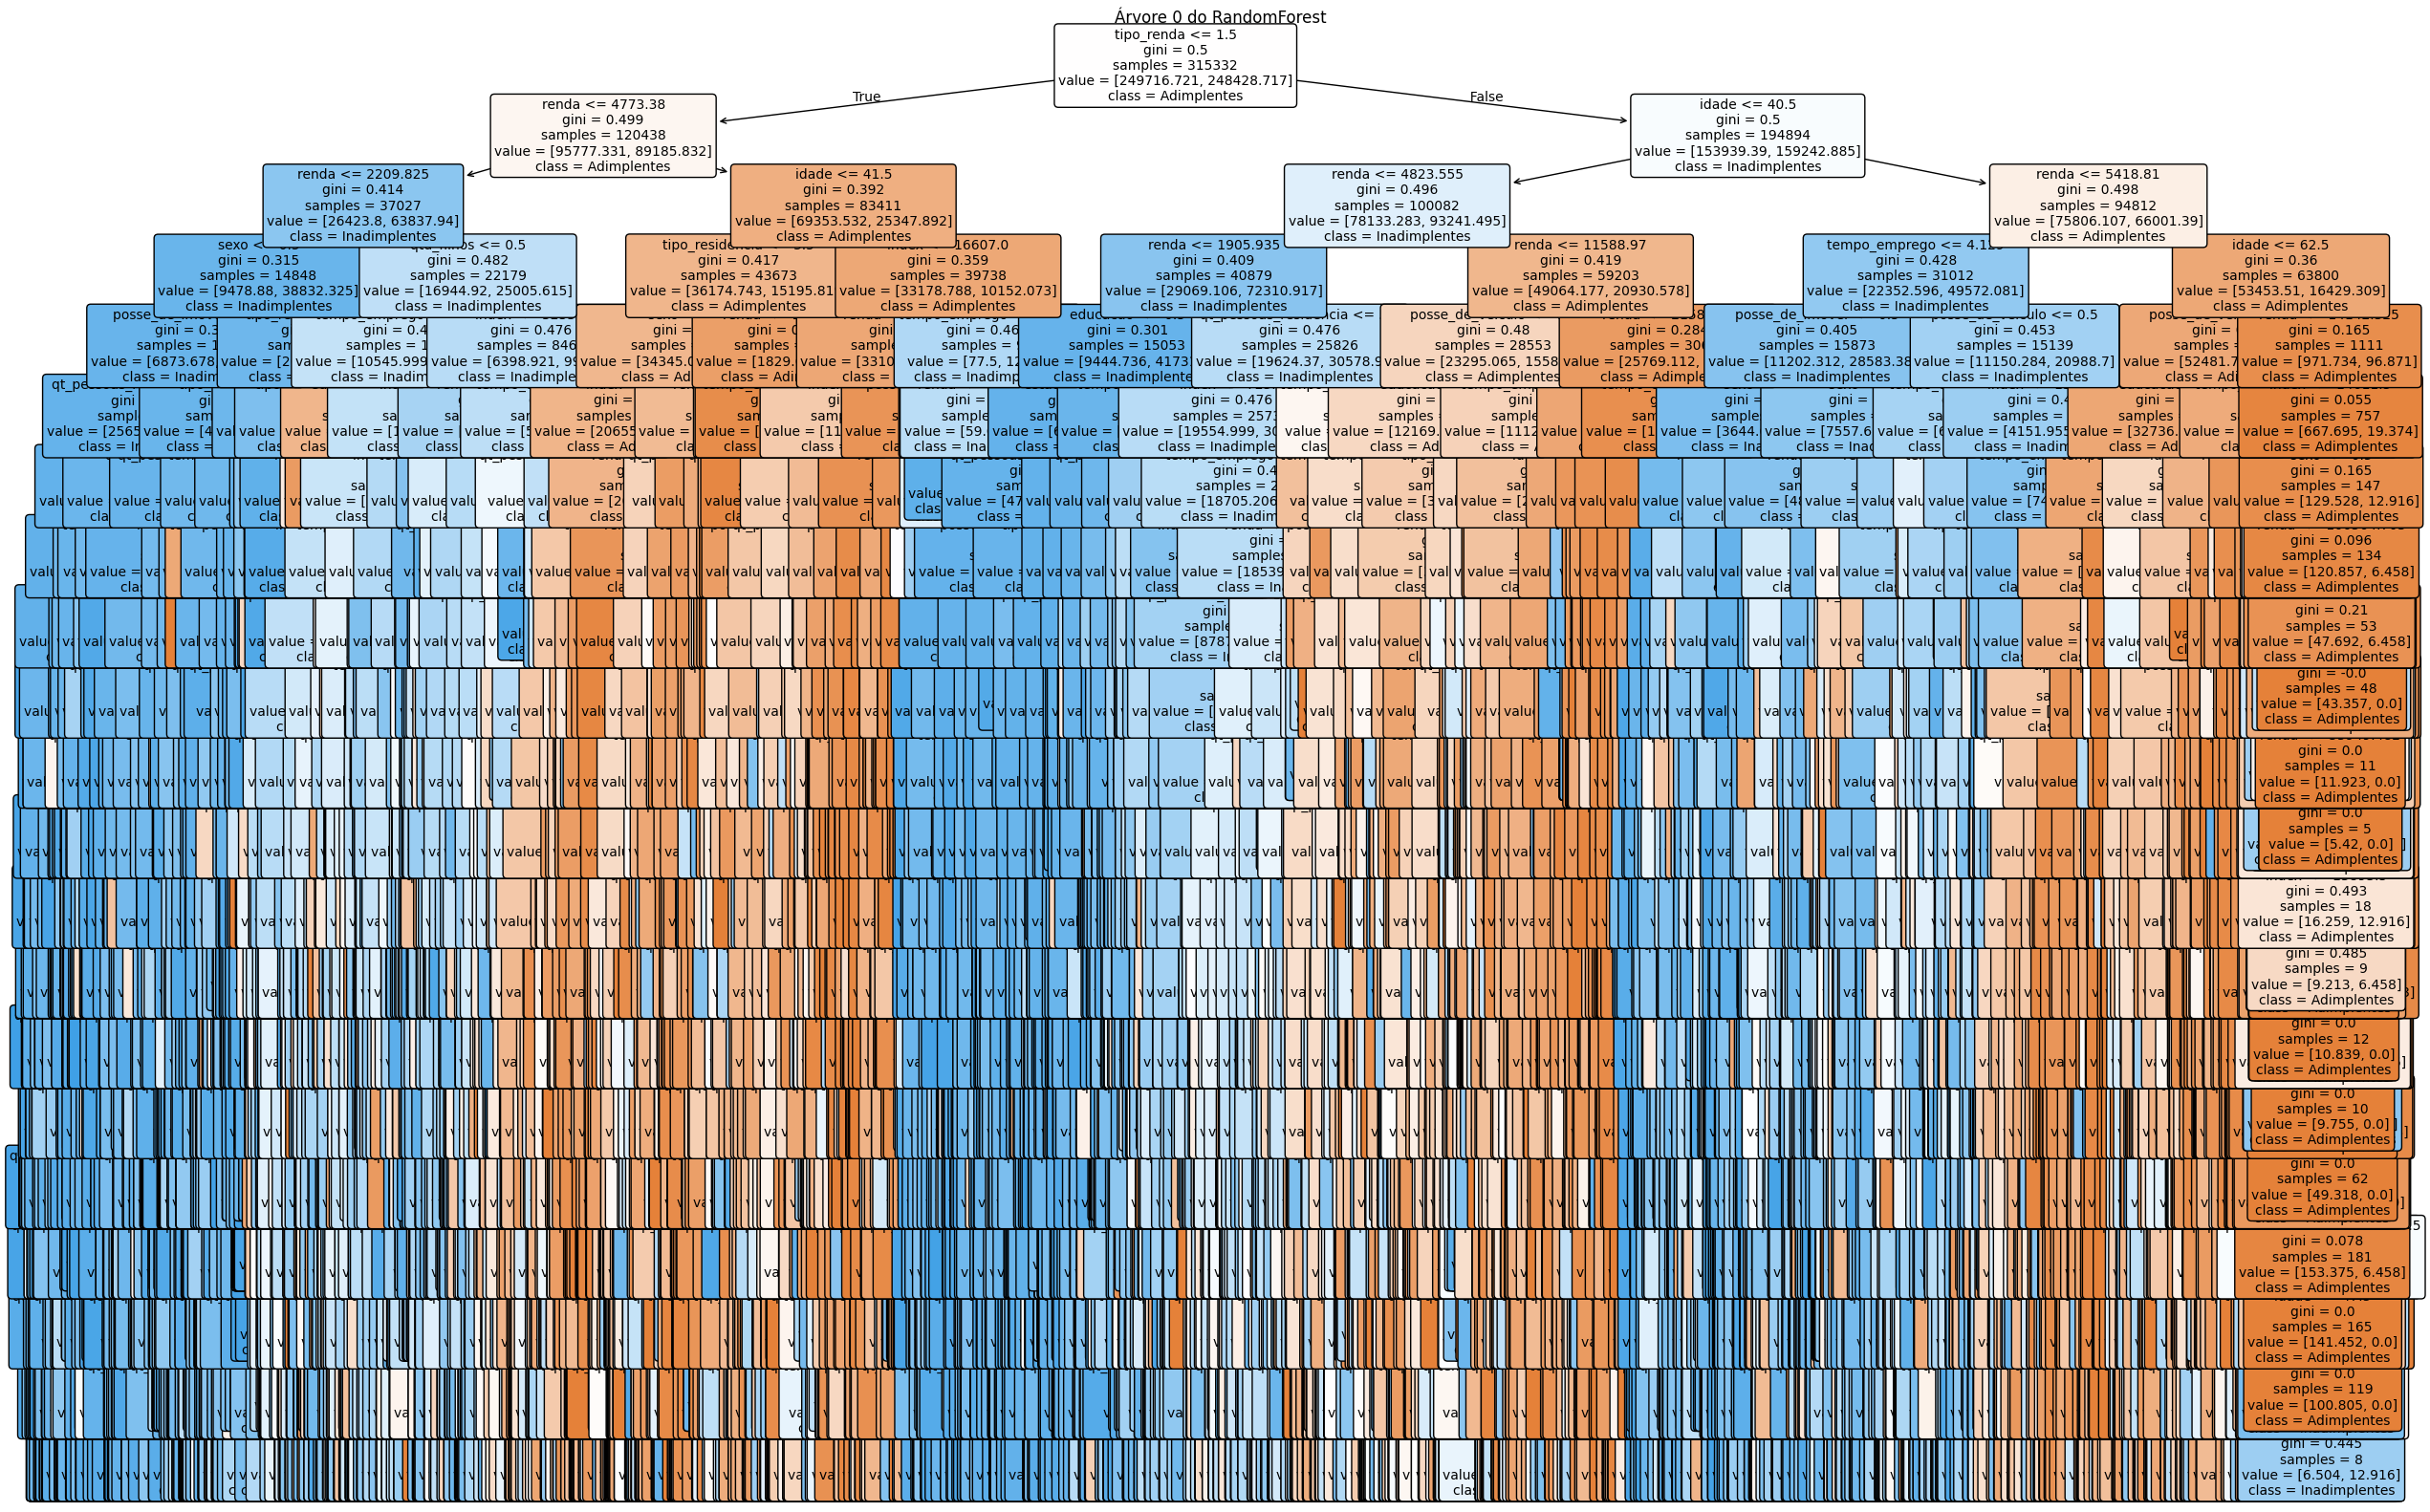

In [55]:
arvore = modelo_floresta_balanceado.estimators_[0]

plt.figure(figsize=(30, 20))

plot_tree(arvore,
          feature_names=X_train.columns,
          class_names=["Adimplentes", "Inadimplentes"],
          filled=True,
          rounded=True,
          fontsize=10)

plt.title("Árvore 0 do RandomForest")
plt.show()

##5.3 Avaliação Final do Modelo Random Forest Balanceado

####Objetivo
Avaliar a performance preditiva do modelo balanceado de Random Forest nos dados de teste, considerando tanto a classificação binária quanto a capacidade probabilística.

####Métricas apresentadas:
- **ROC AUC:** Mede a habilidade do modelo em separar as classes em diferentes thresholds; valores próximos a 1 indicam excelente discriminação.
- **Classification Report:** Fornece precisão, recall, f1-score e suporte para cada classe, essenciais para análise detalhada do comportamento do modelo em cada categoria.




In [44]:
# Predição das classes para o conjunto de teste
y_pred = modelo_floresta_balanceado.predict(X_test)

# Predição das probabilidades da classe positiva (inadimplente)
y_proba = modelo_floresta_balanceado.predict_proba(X_test)[:, 1]

# Cálculo da métrica ROC AUC para avaliação da capacidade discriminativa do modelo
roc_auc = roc_auc_score(y_test, y_proba)

# Impressão da métrica ROC AUC
print("ROC AUC:", roc_auc)

# Impressão do relatório completo de classificação com métricas detalhadas
print(classification_report(y_test, y_pred))

ROC AUC: 0.7605117822530959
              precision    recall  f1-score   support

           0       0.96      0.81      0.88    115224
           1       0.19      0.55      0.29      9585

    accuracy                           0.79    124809
   macro avg       0.57      0.68      0.58    124809
weighted avg       0.90      0.79      0.83    124809



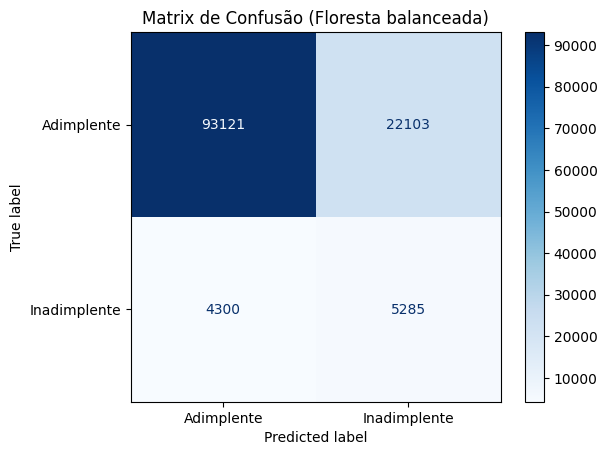

In [49]:
# Calcula a matriz de confusão para os dados de teste
modelo_floresta_balanceada_cm = confusion_matrix(y_test, y_pred, labels=[0, 1])

# Cria o objeto para exibir a matriz de confusão com rótulos customizados
disp = ConfusionMatrixDisplay(
    confusion_matrix=modelo_floresta_balanceada_cm,
    display_labels=["Adimplente", "Inadimplente"]
)

# Plota a matriz de confusão com coloração azul para facilitar a leitura
disp.plot(cmap="Blues")

# Adiciona título ao gráfico
plt.title("Matriz de Confusão (Floresta Balanceada)")

# Exibe o gráfico
plt.show()

##5.4 Determinação do Melhor Threshold com Youden's J Statistic

###Objetivo
Encontrar o **threshold ótimo de decisão** para classificar inadimplentes com base nas probabilidades previstas pelo modelo, maximizando o equilíbrio entre sensibilidade e especificidade.

####Youden's J Statistic
- Fórmula: \( J = \text{TPR} - \text{FPR} \)
- Valor máximo de \( J \) indica o melhor compromisso entre taxa de verdadeiros positivos e falsos positivos.
- Útil para ajustar o cutoff padrão (0.5) da predição probabilística e melhorar a performance prática do modelo.

####Interpretação dos resultados
- `best_threshold`: O ponto de corte recomendado para classificar um cliente como inadimplente.
- `True Positive Rate (Recall)`: Proporção de inadimplentes corretamente identificados com esse threshold.
- `False Positive Rate`: Proporção de bons pagadores incorretamente classificados como inadimplentes.



In [50]:
# Obtém as probabilidades preditas da classe positiva (inadimplente)
y_proba = modelo_floresta_balanceado.predict_proba(X_test)[:, 1]

# Calcula os valores de FPR (False Positive Rate), TPR (True Positive Rate) e thresholds da curva ROC
fpr, tpr, thresholds = roc_curve(y_test, y_proba)

# Calcula a estatística J de Youden para cada threshold: J = TPR - FPR
j_scores = tpr - fpr

# Identifica o índice do melhor threshold que maximiza a estatística J
best_index = j_scores.argmax()

# Obtém o melhor threshold
best_threshold = thresholds[best_index]

# Imprime o melhor threshold e os valores de TPR (recall) e FPR correspondentes
print(f"Melhor threshold (Youden's J): {best_threshold:.2f}")
print(f"True Positive Rate (Recall): {tpr[best_index]:.2f}")
print(f"False Positive Rate: {fpr[best_index]:.2f}")

Melhor threshold (Youden's J): 0.41
True Positive Rate (Recall): 0.66
False Positive Rate: 0.28


In [52]:
# Aplica o melhor threshold encontrado para converter probabilidades em classes binárias
y_pred_best = (y_proba >= best_threshold).astype(int)

# Exibe o relatório de classificação detalhado com o threshold ajustado
print("\nRelatório de Classificação:")
print(classification_report(y_test, y_pred_best, digits=2))


Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.96      0.72      0.82    115224
           1       0.16      0.66      0.26      9585

    accuracy                           0.71    124809
   macro avg       0.56      0.69      0.54    124809
weighted avg       0.90      0.71      0.78    124809



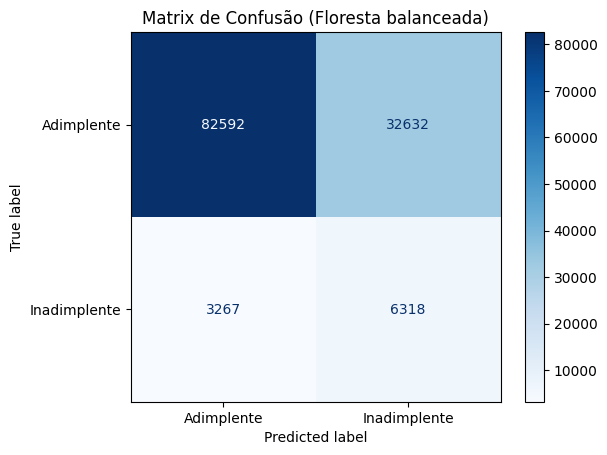

In [53]:
# Calcula a matriz de confusão usando as predições com o threshold ajustado
modelo_floresta_balanceada_cm = confusion_matrix(y_test, y_pred_best, labels=[0, 1])

# Cria o objeto para exibição da matriz de confusão com rótulos customizados
disp = ConfusionMatrixDisplay(
    confusion_matrix=modelo_floresta_balanceada_cm,
    display_labels=["Adimplente", "Inadimplente"]
)

# Plota a matriz com coloração azul para facilitar a leitura
disp.plot(cmap="Blues")

# Adiciona título explicativo ao gráfico
plt.title("Matriz de Confusão (Floresta Balanceada com Threshold Otimizado)")

# Exibe o gráfico
plt.show()

#Avaliação dos Modelos Preditivos para Classificação de Risco de Crédito

Neste estudo, foram comparados dois modelos clássicos de aprendizado supervisionado para classificação binária: Árvore de Decisão e Random Forest, ambos aplicados a um problema de crédito com dados desbalanceados.

**Resultados resumidos**

| Métrica                             | Árvore de Decisão | Random Forest |
| ----------------------------------- | ----------------- | ------------- |
| Accuracy                            | 68%               | 71%           |
| Precision (classe 1 - inadimplente) | 16%               | 16%           |
| Recall (classe 1)                   | 76%               | 66%           |
| F1-score (classe 1)                 | 27%               | 26%           |
| Precision (classe 0)                | 97%               | 96%           |
| Recall (classe 0)                   | 67%               | 72%           |
| F1-score (classe 0)                 | 79%               | 82%           |


**Interpretação das métricas**

Classe majoritária (0 - adimplentes): Ambos os modelos apresentam alta precisão (96-97%) e recall razoável (67-72%). O Random Forest supera a Árvore de Decisão, especialmente em recall e F1-score para essa classe, indicando melhor capacidade em identificar clientes adimplentes corretamente.

**Classe minoritária (1 - inadimplentes)**: Ambas as abordagens apresentam baixa precisão (16%) para esta classe, o que indica que muitos dos clientes classificados como inadimplentes são falsos positivos. O recall é maior na Árvore de Decisão (76% contra 66%), sugerindo que ela detecta mais inadimplentes verdadeiros, porém com maior custo de falsos positivos.

**F1-score da classe 1:** Muito baixo em ambos os casos (~26-27%), refletindo o desafio de classificar corretamente os inadimplentes devido ao desbalanceamento.

**Accuracy**: Apesar de parecer alta (>68%), não é métrica adequada isoladamente para dados desbalanceados, pois o modelo pode "acertar" muitos adimplentes simplesmente por serem maioria.

**Justificativa para a escolha do modelo**

Apesar do recall mais alto para a classe 1 (inadimplentes) no modelo de Árvore de Decisão, o Random Forest apresenta melhor desempenho global, com maior accuracy, recall e F1-score para a classe majoritária e métricas mais equilibradas para o conjunto total (métricas macro e weighted).

Além disso, Random Forest:

* É um modelo ensemble, geralmente mais robusto contra overfitting que árvores individuais.

* Melhora a generalização e a capacidade de capturar padrões complexos nos dados.

* Oferece melhor estabilidade e menor variância no resultado.

* Permite análise de importância das variáveis para insights de negócio.

O ajuste do threshold usando a estatística de Youden pode ajudar a equilibrar ainda mais a sensibilidade (recall) e a especificidade, ajustando o trade-off entre identificar inadimplentes e evitar falsos positivos.

**Considerações finais**

Dado o contexto de mitigação de risco de crédito, o objetivo principal é identificar inadimplentes corretamente (maximizar recall da classe 1), minimizando custos por falsos negativos (inadimplentes não detectados).

* A Árvore de Decisão alcança maior recall para inadimplentes, porém com menor precisão e maior risco de falsos positivos, o que pode impactar negativamente clientes bons.
* O Random Forest oferece um equilíbrio melhor, maior robustez e potencial para ajustes finos via threshold.

Portanto, o modelo Random Forest ajustado com threshold otimizado é a melhor escolha para implementação prática, pois proporciona maior precisão global, robustez e capacidade de balancear os erros conforme as necessidades do negócio.